In [2]:
import new_analysis
import pandas as pd
import root_pandas as rp
import numpy as np
import matplotlib.pyplot as plt
import ROOT
import array
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.lines import Line2D
from matplotlib import rc
rc('text', usetex=True)

Welcome to JupyROOT 6.18/04


/Users/vahsengrouplaptop/workspace/jeff_workspace/analysis/phase3/new_analysis.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  means[col]=0 #will be deleted at the end. Used so we can append rows of means
/Users/vahsengrouplaptop/workspace/jeff_workspace/analysis/phase3/new_analysis.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errs[col] = 0


In [3]:
a = new_analysis.analysis()

In [4]:
data = a.get_raw_study_data()
data.columns
avg1 = a.compute_means_and_errs('LER', 'Cont_inj', 5)
avg2 = a.compute_means_and_errs('LER', 'Decay', 5)
avg3 = a.compute_means_and_errs('HER', 'Cont_inj', 5)
avg4 = a.compute_means_and_errs('HER', 'Decay', 5)
data_avg = avg1.append([avg2,avg3,avg4])
data_avg.index = [i for i in range(0,len(data_avg))]
data_avg['ts_err']= data_avg['ts_err']/3600
data_avg['ts']=(data_avg['ts']-data['ts'].iloc[0])/3600
data['ts']=(data['ts']-data['ts'].iloc[0])/3600

In [5]:
data_avg.keys()

Index(['ts', 'I_HER', 'I_LER', 'P_HER', 'P_LER', 'Sy_HER', 'Sy_LER',
       'ECL_lumi', 'LER_study_flag', 'HER_study_flag', 'Lumi_study_flag',
       'Cont_inj_flag', 'Decay_flag', 'Nb_HER', 'Nb_LER', 'tako_neutrons',
       'palila_neutrons', 'elepaio_neutrons', 'iiwi_neutrons', 'nene_neutrons',
       'humu_neutrons', 'ts_err', 'I_HER_err', 'I_LER_err', 'P_HER_err',
       'P_LER_err', 'Sy_HER_err', 'Sy_LER_err', 'ECL_lumi_err',
       'tako_neutrons_err', 'palila_neutrons_err', 'elepaio_neutrons_err',
       'iiwi_neutrons_err', 'nene_neutrons_err', 'humu_neutrons_err'],
      dtype='object')

In [6]:
bins = 5
study_types = ['LER', 'HER']
study_periods = ["Cont_inj", "Decay"]
tpcs = ['iiwi', 'nene', 'humu', 'palila', 'tako', 'elepaio']
fit_params = {}
fit_bg  = {}
fit_bg_err = {}
fit_t = {}
fit_t_err = {}
fit = {}
fit_err = {}
for study_type in study_types:
    for study_period in study_periods:
        fit_params[study_period + '_' + study_type] = a.get_fit_parameters(study_type, study_period, bins)
        for tpc in tpcs:
            fit_bg[tpc+'_'+study_period+'_'+ study_type] = fit_params[study_period + '_' + study_type][tpc+'_B0']*data_avg['I_%s'%(study_type)] + fit_params[study_period + '_' + study_type][tpc+'_B1']*data_avg['I_%s'%(study_type)]**2
            fit_bg_err[tpc+'_'+study_period+ '_'+study_type] = np.sqrt((fit_params[study_period + '_' + study_type][tpc+'_B0_err']*data_avg['I_%s'%(study_type)])**2 + (fit_params[study_period + '_' + study_type][tpc+'_B1_err']*data_avg['I_%s'%(study_type)]**2)**2)
            fit_t[tpc+'_'+study_period+'_'+ study_type] = fit_params[study_period + '_' + study_type][tpc+'_T']*data_avg['I_%s'%(study_type)]**2/(data_avg['Sy_%s'%(study_type)]*data_avg['Nb_%s'%(study_type)])
            fit_t_err[tpc+'_'+study_period+'_'+ study_type] = fit_params[study_period + '_' + study_type][tpc+'_T_err']*data_avg['I_%s'%(study_type)]**2/(data_avg['Sy_%s'%(study_type)]*data_avg['Nb_%s'%(study_type)])
            fit[tpc+'_'+study_period+'_'+ study_type] = fit_params[study_period + '_' + study_type][tpc+'_B0']*data_avg['I_%s'%(study_type)] + fit_params[study_period + '_' + study_type][tpc+'_B1']*data_avg['I_%s'%(study_type)]**2 + fit_params[study_period + '_' + study_type][tpc+'_T']*data_avg['I_%s'%(study_type)]**2/(data_avg['Sy_%s'%(study_type)]*data_avg['Nb_%s'%(study_type)])
            #fit_err[tpc+'_'+study_period+'_'+ study_type] = np.sqrt(fit_bg_err[tpc+'_'+study_period+'_' + study_type]**2 + fit_t_err[tpc+'_'+study_period+'_' + study_type]**2)
            #use stat error for now
            fit_err[tpc+'_'+study_period+'_'+ study_type] = np.sqrt(((fit_params[study_period + '_' + study_type][tpc+'_B0']+ 2*fit_params[study_period + '_' + study_type][tpc+'_B1']**data_avg['I_%s'%(study_type)] + 
                                                                      2*fit_params[study_period + '_' + study_type][tpc+'_T']**data_avg['I_%s'%(study_type)]/(data_avg['Sy_%s'%(study_type)]*data_avg['Nb_%s'%(study_type)]))*data_avg['I_%s_err'%(study_type)])**2 + ((fit_params[study_period + '_' + study_type][tpc+'_T']**data_avg['I_%s'%(study_type)]**2/(data_avg['Sy_%s'%(study_type)]**2*data_avg['Nb_%s'%(study_type)]))*data_avg['Sy_%s_err'%(study_type)])**2)
            

 FCN=42.2643 FROM MINOS     STATUS=SUCCESSFUL     55 CALLS         370 TOTAL
                     EDM=1.1242e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.96919e-04   1.72995e-04   2.16158e-04   2.32377e-02
   2  p1           3.30647e-16   5.62054e-08  -5.75740e-07** at limit **
   3  p2           2.63476e-02   1.09859e-02   1.09859e-02  -6.54560e-04
 FCN=88.41 FROM MINOS     STATUS=SUCCESSFUL     42 CALLS         316 TOTAL
                     EDM=5.35916e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.06357e-03   2.53241e-04   3.63294e-04  -3.59771e-01
   2  p1           1.35242e-16   5.54409e-08  -9.67708e-07** at limit **
   3  p2           4.33611e-02   1.5

Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <Fit>: Abnormal termination of minimization.
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existi

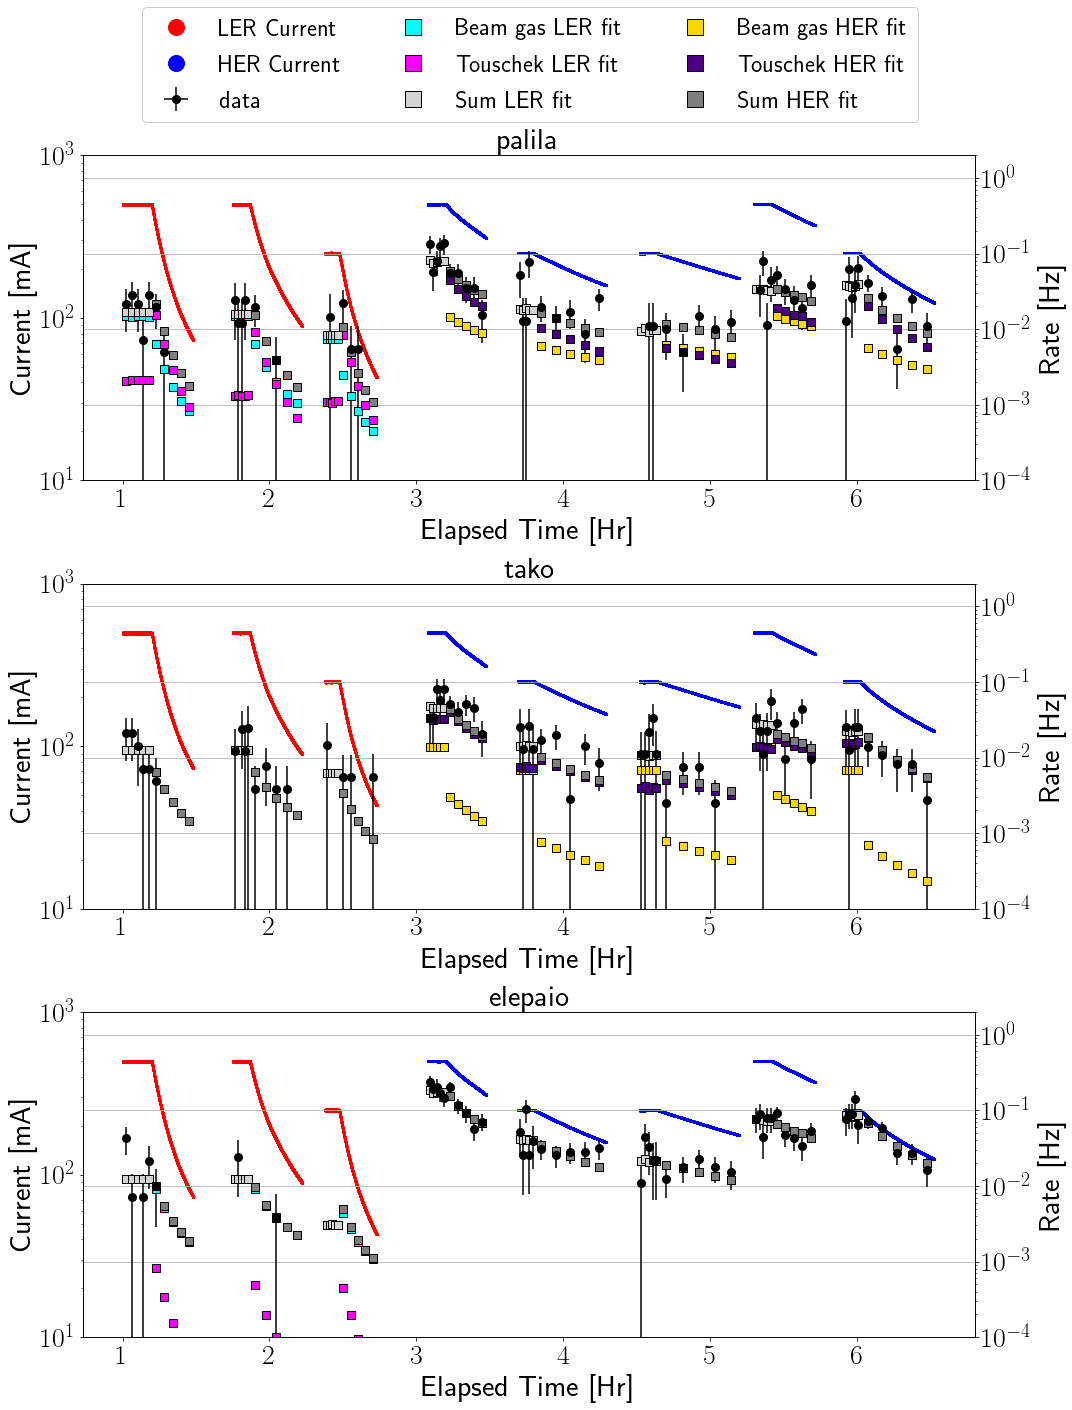

In [28]:
plt.rc('legend', fontsize=24)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rc('axes', labelsize=30)
plt.rc('axes', titlesize=30)
plt.figure(figsize = (15,18))
i = 1
for tpc in ['palila', 'tako', 'elepaio']:
    plt.subplot(3,1,i)
    plt.plot(data.loc[(data['LER_study_flag']==1) & (data['Cont_inj_flag']==1)]['ts'], data.loc[(data['LER_study_flag']==1) & (data['Cont_inj_flag']==1)]['I_LER'], 'o', color = 'red',markersize = 2)
    plt.plot(data.loc[(data['LER_study_flag']==1) & (data['Decay_flag']==1)]['ts'], data.loc[(data['LER_study_flag']==1) & (data['Decay_flag']==1)]['I_LER'], 'o', color = 'red',markersize = 2)
    plt.plot(data.loc[(data['HER_study_flag']==1) & (data['Cont_inj_flag']==1)]['ts'], data.loc[(data['HER_study_flag']==1) & (data['Cont_inj_flag']==1)]['I_HER'], 'o', color = 'blue',markersize = 2)
    plt.plot(data.loc[(data['HER_study_flag']==1) & (data['Decay_flag']==1)]['ts'], data.loc[(data['HER_study_flag']==1) & (data['Decay_flag']==1)]['I_HER'], 'o', color = 'blue',markersize = 2)
    plt.ylim(10,1000)
    plt.ylabel("Current [mA]")
    plt.xlabel('Elapsed Time [Hr]')
    plt.yscale("Log")
    plt.title("%s"%(tpc))
    plt.twinx()
    plt.grid()
    #if i%2 != 1:
    #    plt.ylim(0,1.5)
    #else:
    #    if i != 5:
    #        plt.ylim(0,0.2)
    #    else:
    #        plt.ylim(0,0.4)
    plt.yscale("Log")
    plt.ylim(1e-4,2)
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit_bg['%s_Cont_inj_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'cyan', label = 'Predicted beam-gas rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit_bg['%s_Cont_inj_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'gold', label = 'Predicted beam-gas rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit_bg['%s_Decay_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'cyan', label = 'Predicted beam-gas rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit_bg['%s_Decay_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'gold', label = 'Predicted beam-gas rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit_t['%s_Cont_inj_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'magenta', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit_t['%s_Cont_inj_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'indigo', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit_t['%s_Decay_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'magenta', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit_t['%s_Decay_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'indigo', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit['%s_Cont_inj_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'lightgray', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit['%s_Cont_inj_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'lightgray', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit['%s_Decay_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'tab:gray', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit['%s_Decay_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'tab:gray', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    p = plt.errorbar(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)][tpc+'_neutrons'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)][tpc+'_neutrons_err'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts_err'], 'o', markersize = 8, color = 'black', label = 'data')
    plt.errorbar(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)][tpc+'_neutrons'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)][tpc+'_neutrons_err'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts_err'], 'o', markersize = 8, color = 'black', label = 'data')
    plt.errorbar(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)][tpc+'_neutrons'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)][tpc+'_neutrons_err'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts_err'], 'o', markersize = 8, color = 'black', label = 'data')
    plt.errorbar(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)][tpc+'_neutrons'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)][tpc+'_neutrons_err'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts_err'], 'o', markersize = 8, color = 'black', label = 'data')
    plt.ylabel("Rate [Hz]")
    custom_lines = [Line2D([0], [0], color='red', label='LER Current', marker='o', linewidth = 0, markersize = 16),
                    Line2D([0], [0], color='blue', label='HER Current', marker='o', linewidth = 0, markersize = 16),
                    p,
                Line2D([0], [0], color='cyan', label='Beam gas LER fit', marker='s',markeredgecolor = 'black', linewidth = 0, markersize = 16),
                    Line2D([0], [0], color='magenta', label='Touschek LER fit', marker='s',markeredgecolor = 'black', linewidth = 0, markersize = 16),
                    Line2D([0], [0], color='lightgray', label='Sum LER fit', marker='s',markeredgecolor = 'black', linewidth = 0, markersize = 16),
                Line2D([0], [0], color='gold', label='Beam gas HER fit', marker='s', markeredgecolor = 'black',linewidth = 0, markersize = 16),
                   Line2D([0], [0], color='indigo', label='Touschek HER fit', marker='s', markeredgecolor = 'black',linewidth = 0, markersize = 16),
                    Line2D([0], [0], color='tab:gray', label='Sum HER fit', marker='s', markeredgecolor = 'black',linewidth = 0, markersize = 16)
                   ]
    i += 1
plt.tight_layout()
plt.legend(handles=custom_lines, loc='lower right', framealpha = 1, ncol = 3, bbox_to_anchor=(0.95, 3.7))
plt.savefig("fit_comparison_bwd.png", bbox_inches='tight')

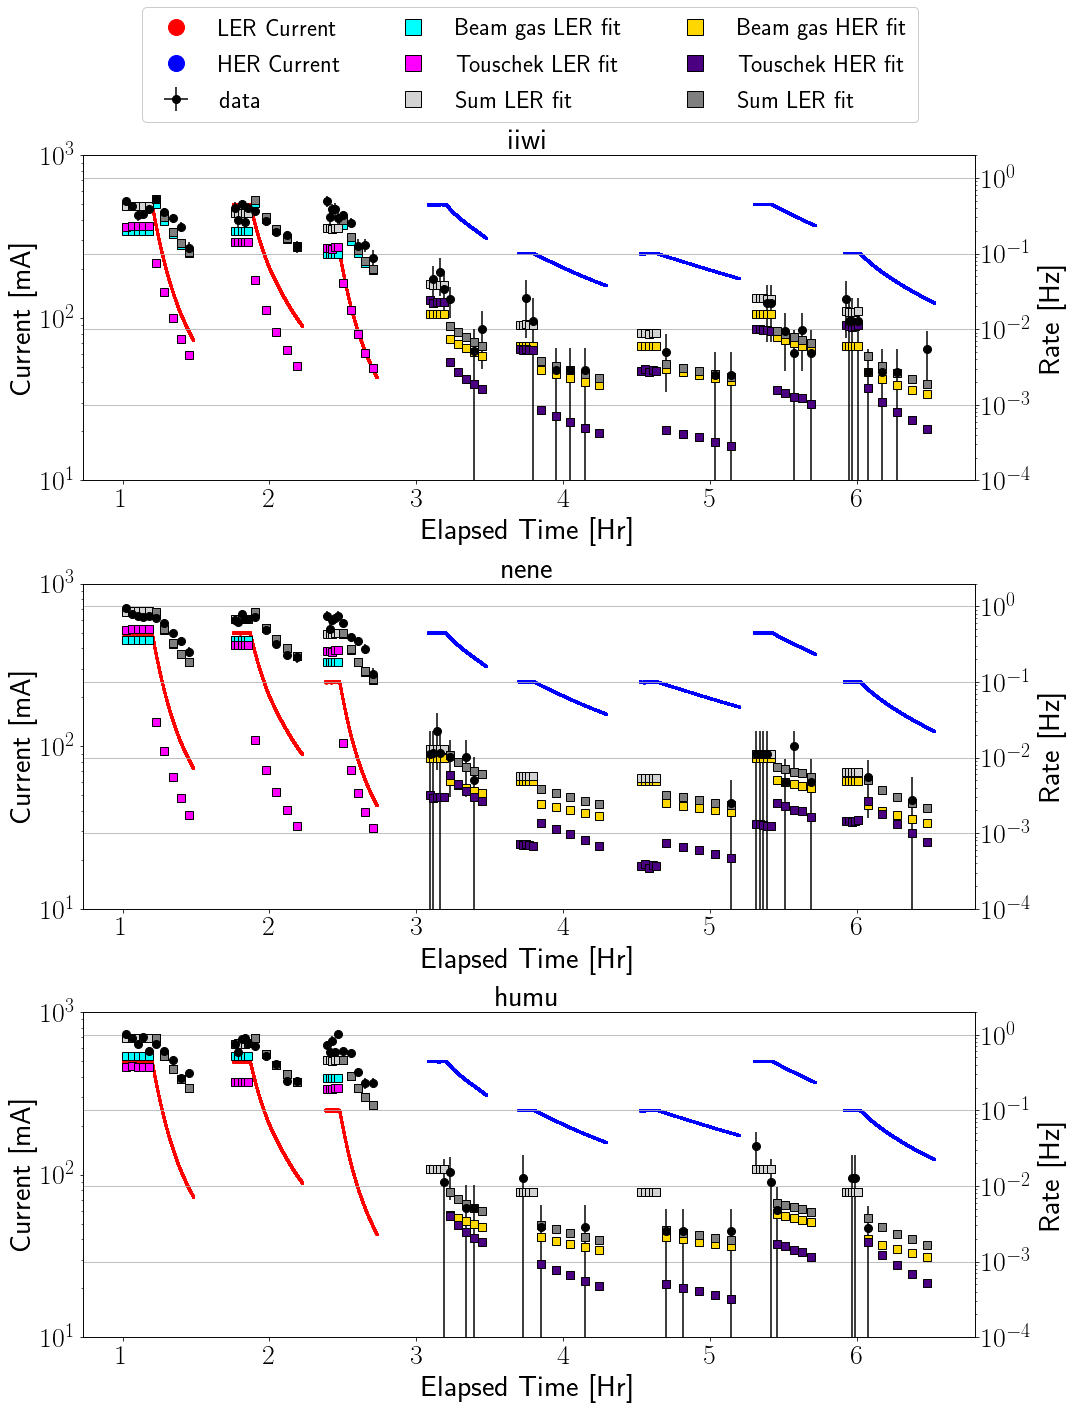

In [29]:
plt.rc('legend', fontsize=24)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rc('axes', labelsize=30)
plt.rc('axes', titlesize=30)
plt.figure(figsize = (15,18))
i = 1
for tpc in ['iiwi', 'nene', 'humu']:
    plt.subplot(3,1,i)
    plt.plot(data.loc[(data['LER_study_flag']==1) & (data['Cont_inj_flag']==1)]['ts'], data.loc[(data['LER_study_flag']==1) & (data['Cont_inj_flag']==1)]['I_LER'], 'o', color = 'red',markersize = 2)
    plt.plot(data.loc[(data['LER_study_flag']==1) & (data['Decay_flag']==1)]['ts'], data.loc[(data['LER_study_flag']==1) & (data['Decay_flag']==1)]['I_LER'], 'o', color = 'red',markersize = 2)
    plt.plot(data.loc[(data['HER_study_flag']==1) & (data['Cont_inj_flag']==1)]['ts'], data.loc[(data['HER_study_flag']==1) & (data['Cont_inj_flag']==1)]['I_HER'], 'o', color = 'blue',markersize = 2)
    plt.plot(data.loc[(data['HER_study_flag']==1) & (data['Decay_flag']==1)]['ts'], data.loc[(data['HER_study_flag']==1) & (data['Decay_flag']==1)]['I_HER'], 'o', color = 'blue',markersize = 2)
    plt.ylim(10,1000)
    plt.ylabel("Current [mA]")
    plt.xlabel('Elapsed Time [Hr]')
    plt.yscale("Log")
    plt.title("%s"%(tpc))
    plt.twinx()
    plt.grid()
    #if i%2 != 1:
    #    plt.ylim(0,1.5)
    #else:
    #    if i != 5:
    #        plt.ylim(0,0.2)
    #    else:
    #        plt.ylim(0,0.4)
    plt.yscale("Log")
    plt.ylim(1e-4,2)
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit_bg['%s_Cont_inj_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'cyan', label = 'Predicted beam-gas rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit_bg['%s_Cont_inj_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'gold', label = 'Predicted beam-gas rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit_bg['%s_Decay_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'cyan', label = 'Predicted beam-gas rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit_bg['%s_Decay_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'gold', label = 'Predicted beam-gas rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit_t['%s_Cont_inj_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'magenta', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit_t['%s_Cont_inj_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'indigo', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit_t['%s_Decay_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'magenta', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit_t['%s_Decay_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'indigo', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit['%s_Cont_inj_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'lightgray', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit['%s_Cont_inj_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'lightgray', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit['%s_Decay_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'tab:gray', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit['%s_Decay_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'tab:gray', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    p = plt.errorbar(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)][tpc+'_neutrons'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)][tpc+'_neutrons_err'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts_err'], 'o', markersize = 8, color = 'black', label = 'data')
    plt.errorbar(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)][tpc+'_neutrons'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)][tpc+'_neutrons_err'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts_err'], 'o', markersize = 8, color = 'black', label = 'data')
    plt.errorbar(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)][tpc+'_neutrons'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)][tpc+'_neutrons_err'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts_err'], 'o', markersize = 8, color = 'black', label = 'data')
    plt.errorbar(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)][tpc+'_neutrons'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)][tpc+'_neutrons_err'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts_err'], 'o', markersize = 8, color = 'black', label = 'data')
    plt.ylabel("Rate [Hz]")
    custom_lines = [Line2D([0], [0], color='red', label='LER Current', marker='o', linewidth = 0, markersize = 16),
                    Line2D([0], [0], color='blue', label='HER Current', marker='o', linewidth = 0, markersize = 16),
                    p,
                Line2D([0], [0], color='cyan', label='Beam gas LER fit', marker='s',markeredgecolor = 'black', linewidth = 0, markersize = 16),
                    Line2D([0], [0], color='magenta', label='Touschek LER fit', marker='s',markeredgecolor = 'black', linewidth = 0, markersize = 16),
                    Line2D([0], [0], color='lightgray', label='Sum LER fit', marker='s',markeredgecolor = 'black', linewidth = 0, markersize = 16),
                Line2D([0], [0], color='gold', label='Beam gas HER fit', marker='s', markeredgecolor = 'black',linewidth = 0, markersize = 16),
                   Line2D([0], [0], color='indigo', label='Touschek HER fit', marker='s', markeredgecolor = 'black',linewidth = 0, markersize = 16),
                    Line2D([0], [0], color='tab:gray', label='Sum LER fit', marker='s', markeredgecolor = 'black',linewidth = 0, markersize = 16)
                   ]
    i += 1
plt.tight_layout()
plt.legend(handles=custom_lines, loc='lower right', framealpha = 1, ncol = 3, bbox_to_anchor=(0.95, 3.7))
plt.savefig("fit_comparison_fwd.png", bbox_inches='tight')